## Runtime Environment

* python >= 3.7
* pytorch >= 1.0
* pandas
* nltk
* numpy
* sklearn
* pickle
* tqdm
* json

# Set Random Seed

In [1]:
from ipywidgets import FloatProgress
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import torch
torch.manual_seed(42)

# Take a  view of dataset

In [4]:
import pandas as pd

dataset = pd.read_csv('data/task2_trainset.csv', dtype=str)
dataset.head()

,Id,Title,Abstract,Authors,Categories,Created Date,Task 2
0,D00001,A Brain-Inspired Trust Management Model to Ass...,Rapid popularity of Internet of Things (IoT) a...,Mahmud/Kaiser/Rahman/Rahman/Shabut/Al-Mamun/Hu...,cs.CR/cs.AI/q-bio.NC,2018-01-11,THEORETICAL
1,D00002,On Efficient Computation of Shortest Dubins Pa...,"In this paper, we address the problem of compu...",Sadeghi/Smith,cs.SY/cs.RO/math.OC,2016-09-21,THEORETICAL
2,D00003,Data-driven Upsampling of Point Clouds,High quality upsampling of sparse 3D point clo...,Zhang/Jiang/Yang/Yamakawa/Shimada/Kara,cs.CV,2018-07-07,ENGINEERING
3,D00004,Accessibility or Usability of InteractSE? A He...,Internet is the main source of information now...,Aqle/Khowaja/Al-Thani,cs.HC,2018-08-29,EMPIRICAL
4,D00005,Spatio-Temporal Facial Expression Recognition ...,Automated Facial Expression Recognition (FER) ...,Hasani/Mahoor,cs.CV,2017-03-20,ENGINEERING


**Id**: 流水號  
**Title**: 論文標題  
**Abstract**: 論文摘要內容, 句子間以 **$$$** 分隔  
**Authors**: 論文作者  
**Categories**: 論文類別  
**Created date**: 論文上傳日期  
**Task 2**: 論文分類類別, 若句子有多個類別,以 **空格** 分隔 

# Data processing

## 刪除多於資訊 (Remove redundant information)  
我們在資料集中保留了許多額外資訊供大家使用，但是在這次的教學中我們並沒有用到全部資訊，因此先將多餘的部分先抽走。  
In dataset, we reserved lots of information. But in this tutorial, we don't need them, so we need to discard them.

In [5]:
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)

In [6]:
dataset.head()

,Id,Abstract,Task 2
0,D00001,Rapid popularity of Internet of Things (IoT) a...,THEORETICAL
1,D00002,"In this paper, we address the problem of compu...",THEORETICAL
2,D00003,High quality upsampling of sparse 3D point clo...,ENGINEERING
3,D00004,Internet is the main source of information now...,EMPIRICAL
4,D00005,Automated Facial Expression Recognition (FER) ...,ENGINEERING


## 資料切割  (Partition)
在訓練時，我們需要有個方法去檢驗訓練結果的好壞，因此需要將訓練資料切成training/validataion set。   
While training, we need some method to exam our model's performance, so we divide our training data into training/validataion set.

In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

trainset, validset = train_test_split(dataset, test_size=0.1, random_state=42)

trainset.to_csv('trainset.csv', index=False)
validset.to_csv('validset.csv', index=False)

### For test data

In [8]:
dataset = pd.read_csv('data/task2_public_testset.csv', dtype=str)
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)
dataset.to_csv('testset.csv',index=False)

### 統計單字 (Count words)  
在訓練時，不能直接將單字直接餵入model，因為它只看得懂數字，因此我們必須把所有的單字抽取出來，並將它們打上編號，做出一個字典來對它們做轉換。
We can't feed "word" into model directly, since it can only recognize number. So, we need to know the total number of word, and give every word a unique number.  

在這裡，我們需要借助`nltk`這個library來幫忙做文字切割。當然，你也可以選擇自己寫規則來切割(通常上不建議搞死自己)。  
另外，我們也使用了`multiprocessing`來加速處理。  
In here, we split words by using `nltk library`. You can write your own rules and split it by yourself, but you won't want to do that, trust me.  
Also, we use `multiprocessing` to accelerate the process.

[Async處理](https://feelncut.com/2018/05/14/150.html)

In [9]:
from multiprocessing import Pool
from nltk.tokenize import word_tokenize

def collect_words(data_path, n_workers=4):
    df = pd.read_csv(data_path, dtype=str)
        
    sent_list = []
    for i in df.iterrows():
        sent_list += i[1]['Abstract'].split('$$$')
        
     # 平行化處理
    chunks = [
        ' '.join(sent_list[i:i + len(sent_list) // n_workers])
        for i in range(0, len(sent_list), len(sent_list) // n_workers)
    ]
    with Pool(n_workers) as pool:
        chunks = pool.map_async(word_tokenize, chunks)
        words = set(sum(chunks.get(), []))

    return words

In [10]:
%%time
words = set()
words |= collect_words('trainset.csv', n_workers=8)

CPU times: user 676 ms, sys: 72.8 ms, total: 749 ms
Wall time: 1.94 s


pad: for padding  
unk: for word that didn't in our dicitonary

In [11]:
PAD_TOKEN = 0
UNK_TOKEN = 1
word_dict = {'<pad>':PAD_TOKEN,'<unk>':UNK_TOKEN}
for word in words:
    word_dict[word]=len(word_dict)

In [12]:
import pickle

with open('dicitonary.pkl','wb') as f:
    pickle.dump(word_dict, f)

## Embedding class to save pretrained embedding

In [13]:
import re
import torch

class Embedding:
    """
    Args:
        embedding_path (str): Path where embedding are loaded from (text file).
        words (None or list): If not None, only load embedding of the words in
            the list.
        oov_as_unk (bool): If argument `words` are provided, whether or not
            treat words in `words` but not in embedding file as `<unk>`. If
            true, OOV will be mapped to the index of `<unk>`. Otherwise,
            embedding of those OOV will be randomly initialize and their
            indices will be after non-OOV.
        lower (bool): Whether or not lower the words.
        rand_seed (int): Random seed for embedding initialization.
    """

    def __init__(self, embedding_path, words=None, oov_as_unk=True, lower=True, rand_seed=524):
        self.word_dict = {}
        self.vectors = None 
        self.lower = lower # 要不要變小寫
        self.extend(embedding_path, words, oov_as_unk)
        torch.manual_seed(rand_seed) # random seed

        if '<pad>' not in self.word_dict:
            self.add(
                '<pad>', torch.zeros(self.get_dim())
            )
        
        if '<bos>' not in self.word_dict:
            t_tensor = torch.rand((1, self.get_dim()), dtype=torch.float)
            torch.nn.init.orthogonal_(t_tensor)
            self.add(
                '<bos>', t_tensor
            )
            
        if '<eos>' not in self.word_dict:
            t_tensor = torch.rand((1, self.get_dim()), dtype=torch.float)
            torch.nn.init.orthogonal_(t_tensor)
            self.add(
                '<eos>', t_tensor
            )
        
        if '<unk>' not in self.word_dict:
            self.add('<unk>')

    def to_index(self, word):
        """
        Args:
            word (str)

        Return:
             index of the word. If the word is not in `words` and not in the
             embedding file, then index of `<unk>` will be returned.
        """
        if self.lower:
            word = word.lower()

        if word not in self.word_dict:
            return self.word_dict['<unk>']
        else:
            return self.word_dict[word]

    def get_dim(self):
        return self.vectors.shape[1]

    def get_vocabulary_size(self):
        return self.vectors.shape[0]

    def add(self, word, vector=None):
        if self.lower:
            word = word.lower()

        if vector is not None:
            # 不同維度觀點，不改變mem
            vector = vector.view(1, -1)
        else:
            vector = torch.empty(1, self.get_dim())
# Fills the input Tensor with values drawn from the uniform distribution 
            torch.nn.init.uniform_(vector) 
# catenate.. must be the same shape, axis = 0
        self.vectors = torch.cat([self.vectors, vector], 0)
        self.word_dict[word] = len(self.word_dict)

    def extend(self, embedding_path, words, oov_as_unk=True):
        self._load_embedding(embedding_path, words)

        if words is not None and not oov_as_unk:
            # initialize word vector for OOV
            for word in words:
                if self.lower:
                    word = word.lower()

                if word not in self.word_dict:
                    self.word_dict[word] = len(self.word_dict)

            oov_vectors = torch.nn.init.uniform_(
                torch.empty(len(self.word_dict) - self.vectors.shape[0],
                            self.vectors.shape[1]))

            self.vectors = torch.cat([self.vectors, oov_vectors], 0)

    def _load_embedding(self, embedding_path, words):
        if words is not None:
            words = set(words)

        vectors = []

        with open(embedding_path) as fp:

            row1 = fp.readline()
            # if the first row is not header
            if not re.match('^[0-9]+ [0-9]+$', row1):
                # seek to 0
# 0: means your reference point is the beginning of the file
# 1: means your reference point is the current file position
# 2: means your reference point is the end of the file
                fp.seek(0)
            # otherwise ignore the header

            for i, line in enumerate(fp):
                cols = line.rstrip().split(' ')
                word = cols[0] # 吃字

                # skip word not in words if words are provided
                if words is not None and word not in words:
                    continue
                elif word not in self.word_dict:
                    self.word_dict[word] = len(self.word_dict) # 把model裡的字夾到字典中
                    vectors.append([float(v) for v in cols[1:]]) # 後面的向量

        vectors = torch.tensor(vectors)
        if self.vectors is not None:
            # 更新原本的值
            self.vectors = torch.cat([self.vectors, vectors], dim=0)
        else:
            self.vectors = vectors


In [14]:
len(words)

39844

In [15]:
# download Glove pretrained word embedding from web.
embedder = Embedding('data/glove.6B.300d.txt', words)

In [16]:
import pickle

with open('embedding.pkl','wb') as f:
    pickle.dump(embedder, f)

### 資料格式化 (Data formatting)  
有了字典後，接下來我們要把資料整理成一筆一筆，把input的句子轉成數字，把答案轉成onehot的形式。  
這裡，我們一樣使用`multiprocessing`來加入進行。  
After building dictionary, that's mapping our sentences into number array, and convert answers to onehot format.  

In [17]:
from tqdm import tqdm_notebook as tqdm

def label_to_onehot(labels):
    """ Convert label to onehot .
        Args:
            labels (string): sentence's labels.
        Return:
            outputs (onehot list): sentence's onehot label.
    """
    label_dict = {'THEORETICAL': 0, 'ENGINEERING':1, 'EMPIRICAL':2, 'OTHERS':3}
    onehot = [0,0,0,0]
    for l in labels.split():
        onehot[label_dict[l]] = 1
    return onehot
        
def sentence_to_indices(sentence, word_dict):
    """ Convert sentence to its word indices.
    Args:
        sentence (str): One string.
    Return:
        indices (list of int): List of word indices.
    """
    return [word_dict.to_index(word) for word in word_tokenize(sentence)]
    
def get_dataset(data_path, word_dict, n_workers=4):
    """ Load data and return dataset for training and validating.

    Args:
        data_path (str): Path to the data.
    """
    dataset = pd.read_csv(data_path, dtype=str)

    results = [None] * n_workers
    with Pool(processes=n_workers) as pool:
        for i in range(n_workers):
            batch_start = (len(dataset) // n_workers) * i
            if i == n_workers - 1: # 跑到底
                batch_end = len(dataset)
            else:
                batch_end = (len(dataset) // n_workers) * (i + 1)
            
            batch = dataset[batch_start: batch_end]
            results[i] = pool.apply_async(preprocess_samples, args=(batch,word_dict)) # 丟到函式內

        pool.close()
        pool.join()

    processed = []
    for result in results:
        processed += result.get()
    return processed

def preprocess_samples(dataset, word_dict):
    """ Worker function.

    Args:
        dataset (list of dict)
    Returns:
        list of processed dict.
    """
    processed = []
    for sample in tqdm(dataset.iterrows(), total=len(dataset)):
        processed.append(preprocess_sample(sample[1], word_dict))

    return processed

def preprocess_sample(data, word_dict):
    """
    Args:
        data (dict)
    Returns:
        dict
    """
    processed = {}
    processed['Abstract'] = [sentence_to_indices(sent, word_dict) for sent in data['Abstract'].split('$$$')]
    if 'Task 2' in data: # check if it is train/test
        processed['Label'] = label_to_onehot(data['Task 2'])
        
    return processed

In [19]:
print('[INFO] Start processing trainset...')
train = get_dataset('trainset.csv', embedder, n_workers=4)
print('[INFO] Start processing validset...')
valid = get_dataset('validset.csv', embedder, n_workers=4)
print('[INFO] Start processing testset...')
test = get_dataset('testset.csv', embedder, n_workers=4)

[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing testset...






## 資料封裝 (Data packing)

為了更方便的進行batch training，我們將會借助[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)。  
而要將資料放入dataloader，我們需要繼承[torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)，撰寫適合這份dataset的class。  
`collate_fn`用於batch data的後處理，在`dataloder`將選出的data放進list後會呼叫collate_fn，而我們會在此把sentence padding到同樣的長度，才能夠放入torch tensor (tensor必須為矩陣)。  

To easily training in batch, we'll use `dataloader`, which is a function built in Pytorch[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)  
To use datalaoder, we need to packing our data into class `dataset` [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)  
`collate_fn` is used for data processing.

In [20]:
from torch.utils.data import Dataset
import torch

class AbstractDataset(Dataset):
    def __init__(self, data, pad_idx, max_len = 500):
        self.data = data
        self.pad_idx = pad_idx
        self.max_len = max_len
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_sent = max([len(data['Abstract']) for data in datas])
        max_len = max([min(len(sentence), self.max_len) for data in datas for sentence in data['Abstract']])
        batch_abstract = []
        batch_label = []
        sent_len = []
        for data in datas:
            # padding abstract to make them in same length
            pad_abstract = []
            for sentence in data['Abstract']:
                if len(sentence) > max_len:
                    pad_abstract.append(sentence[:max_len])
                else:
                    pad_abstract.append(sentence+[self.pad_idx]*(max_len-len(sentence)))
            sent_len.append(len(pad_abstract))
            pad_abstract.extend([[self.pad_idx]*max_len]*(max_sent-len(pad_abstract)))
            batch_abstract.append(pad_abstract)
            
            # gather labels
            if 'Label' in data:
                batch_label.append(data['Label'])
                
        return torch.LongTensor(batch_abstract), torch.FloatTensor(batch_label), sent_len

In [21]:
trainData = AbstractDataset(train, PAD_TOKEN)
validData = AbstractDataset(valid, PAD_TOKEN)
testData = AbstractDataset(test, PAD_TOKEN)

# Model

資料處理完成後，接下來就是最重要的核心部分：`Model`。  
此次範例中我們以簡單的一層RNN + 一層Linear layer作為示範。  
而為了解決每次的句子長度不一的問題(`linear layer必須是fixed input size`)，因此我們把所有字的hidden_state做平均，讓這一個vector代表這句話。  

In this tutorial, we're going to implement a simple model, which contain one RNN layer and one fully connected layers (Linear layer). Of course you can make it "deep".  
To solve variant sentence length problem (`input size in linear layer must be fixed`), we can average all hidden_states, and become one vector. (Perfect!)

In [23]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
# import torch.nn as nn
# import torch.nn.functional as F


# class simpleNet(nn.Module):
#     def __init__(self, vocabulary_size):
#         super(simpleNet, self).__init__()
#         self.hidden_dim = 512
#         self.sent_rnn = nn.GRU(vocabulary_size,
#                                 self.hidden_dim,
#                                 bidirectional=True,
#                                 batch_first=True,
#                                 dropout=0.2) # 0.2
#         self.l1 = nn.Linear(self.hidden_dim, 4)
#         self.dropout = nn.Dropout(p=0.3) # 0.3 is good
        
#     def forward(self, x):
#         b,s,w,e = x.shape
#         x = x.view(b,s*w,e)
#         x, __ = self.sent_rnn(x)
#         x = x.view(b,s,w,-1) # 1024
#         x = torch.max(x,dim=2)[0] # 把word拿掉bs*1024
#         x = x[:,:,:self.hidden_dim] + x[:,:,self.hidden_dim:]
#         x = torch.max(x,dim=1)[0]
#         x = self.dropout(self.l1(F.relu(x)))
#         x = torch.sigmoid(x)
#         return x

In [25]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 5
HIDDEN_DIM = 4

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full([self.tagset_size], -10000.)
        # START_TAG has all of the score.
        init_alphas[self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        # Iterate through the sentence
        forward_var_list=[]
        forward_var_list.append(init_alphas)
        for feat_index in range(feats.shape[0]):
            gamar_r_l = torch.stack([forward_var_list[feat_index]] * feats.shape[1])
            t_r1_k = torch.unsqueeze(feats[feat_index],0).transpose(0,1)
            aa = gamar_r_l + t_r1_k + self.transitions
            forward_var_list.append(torch.logsumexp(aa,dim=1))
        terminal_var = forward_var_list[-1] + self.transitions[self.tag_to_ix[STOP_TAG]]
        terminal_var = torch.unsqueeze(terminal_var,0)
        alpha = torch.logsumexp(terminal_var, dim=1)[0]
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []
        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var_list = []
        forward_var_list.append(init_vvars)

        for feat_index in range(feats.shape[0]):
            gamar_r_l = torch.stack([forward_var_list[feat_index]] * feats.shape[1])
            gamar_r_l = torch.squeeze(gamar_r_l)
            next_tag_var = gamar_r_l + self.transitions
            viterbivars_t,bptrs_t = torch.max(next_tag_var,dim=1)

            t_r1_k = torch.unsqueeze(feats[feat_index], 0)
            forward_var_new = torch.unsqueeze(viterbivars_t,0) + t_r1_k

            forward_var_list.append(forward_var_new)
            backpointers.append(bptrs_t.tolist())

        # Transition to STOP_TAG
        terminal_var = forward_var_list[-1] + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = torch.argmax(terminal_var).tolist()
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path


    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

# Training

指定使用的運算裝置  
Designate running device.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

定義一個算分公式, 讓我們在training能快速了解model的效能  
Define score function, let us easily observe model performance while training.  

In [ ]:
class F1():
    def __init__(self):
        self.threshold = 0.5
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0

    def update(self, predicts, groundTruth):
        predicts = predicts > self.threshold
        self.n_precision += torch.sum(predicts).data.item()
        self.n_recall += torch.sum(groundTruth).data.item()
        self.n_corrects += torch.sum(groundTruth.type(torch.uint8) * predicts).data.item()

    def get_score(self):
        recall = self.n_corrects / self.n_recall
        precision = self.n_corrects / (self.n_precision + 1e-20)
        return 2 * (recall * precision) / (recall + precision + 1e-20)

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)


In [ ]:
import os
def _run_epoch(epoch, embedding, training):
    if training:
        model.train(training)
        description = 'Train'
        dataset = trainData
        shuffle = True
    else:
        model.eval()
        description = 'Valid'
        dataset = validData
        shuffle = False
    dataloader = DataLoader(dataset=dataset,
                            batch_size=8,
                            shuffle=shuffle,
                            collate_fn=dataset.collate_fn,
                            num_workers=4)

    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0
    f1_score = F1()
    for i, (x, y, sent_len) in trange:
        x = embedding(x)
        o_labels, batch_loss = _run_iter(x,y)
        if training:
            opt.zero_grad()
            batch_loss.backward()
            opt.step()

        loss += batch_loss.item()
        f1_score.update(o_labels.cpu(), y)

        trange.set_postfix(
            loss=loss / (i + 1), f1=f1_score.print_score())
    if training:
        history['train'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})
    else:
        history['valid'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})

def _run_iter(x,y):
    abstract = x.to(device)
    labels = y.to(device)
    o_labels = model(abstract)
    l_loss = criteria(o_labels, labels)
    return o_labels, l_loss

def save(epoch):
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(model.state_dict(), 'model/model.pkl.'+str(epoch))
    with open('model/history.json', 'w') as f:
        json.dump(history, f, indent=4)

In [ ]:
from torch.utils.data import DataLoader
from tqdm import trange
import json
model = simpleNet(embedder.get_dim())

opt = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)
criteria = torch.nn.BCELoss()
model.to(device)
max_epoch = 25
history = {'train':[],'valid':[]}


embedding = nn.Embedding(embedder.get_vocabulary_size(),embedder.get_dim())
embedding.weight = torch.nn.Parameter(embedder.vectors)
for epoch in range(max_epoch):
    print('Epoch: {}'.format(epoch))
    _run_epoch(epoch, embedding, True)
    _run_epoch(epoch, embedding, False)
    save(epoch)

# Plot

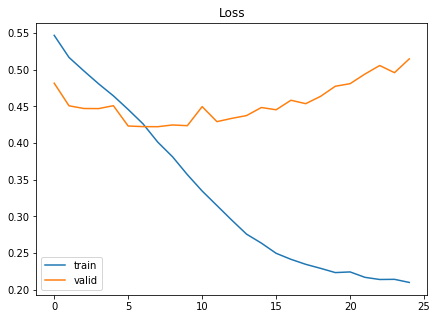

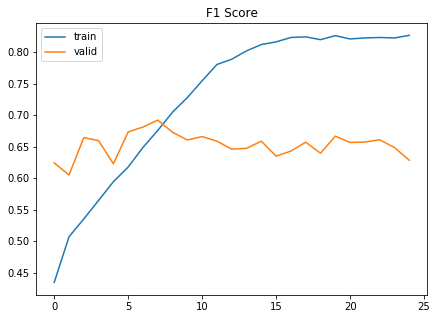

Best F1 score  [0.6921322690992018, 7]


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

with open('model/history.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['f1'], idx] for idx, l in enumerate(history['valid'])]))

## Predict

In [29]:
torch.cuda.empty_cache()

In [30]:
model.load_state_dict(torch.load('model/model.pkl.{}'.format(7)))
model.train(False)
_run_epoch(1, embedding, False)
dataloader = DataLoader(dataset=testData,
                            batch_size=32,
                            shuffle=False,
                            collate_fn=testData.collate_fn,
                            num_workers=4)
trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
prediction = []
for i, (x,y,_l) in trange:
    x = embedding(x)
    o_labels = model(x.to(device))
    o_labels = o_labels>0.5
    prediction.append(o_labels.to('cpu'))

prediction = torch.cat(prediction).detach().numpy().astype(int)

In [31]:
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    """
    Args:
        prediction (numpy array)
        sampleFile (str)
        public (boolean)
        filename (str)
    """
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
        submit['THEORETICAL'] = list(prediction[:,0]) + [0]*redundant
        submit['ENGINEERING'] = list(prediction[:,1]) + [0]*redundant
        submit['EMPIRICAL'] = list(prediction[:,2]) + [0]*redundant
        submit['OTHERS'] = list(prediction[:,3]) + [0]*redundant
    else:
        submit['THEORETICAL'] = [0]*redundant + list(prediction[:,0])
        submit['ENGINEERING'] = [0]*redundant + list(prediction[:,1])
        submit['EMPIRICAL'] = [0]*redundant + list(prediction[:,2])
        submit['OTHERS'] = [0]*redundant + list(prediction[:,3])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

In [32]:
SubmitGenerator(prediction, 
                'data/task2_sample_submission.csv',
                True, 
                'data/task2_submission.csv')